# Smooooooothing

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import ivpsolve, recipes

config.update("jax_enable_x64", True)
backend.select("jax")

In [3]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 1e-1))


@jax.jit
def vf(*ys, t, p):
    return f(*ys, *p)


num_derivatives = 3

In [4]:
ek0, info_op = recipes.dynamic_isotropic_eks0(num_derivatives=num_derivatives)

In [5]:
ek0sol = ivpsolve.solve(
    vf,
    initial_values=(u0,),
    t0=t0,
    t1=t1,
    solver=ek0,
    info_op=info_op,
    parameters=f_args,
)

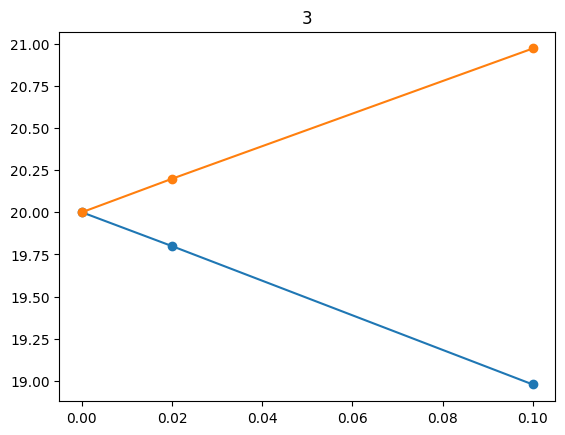

In [6]:
plt.title(len(ek0sol.t))
plt.plot(ek0sol.t, ek0sol.u, "o-")
plt.show()

In [8]:
fixpt_ek0, info_op = recipes.dynamic_isotropic_fixpt_eks0(
    num_derivatives=num_derivatives
)

In [9]:
print()
fixptsol = ivpsolve.simulate_checkpoints(
    vf,
    initial_values=(u0,),
    ts=ek0sol.t,
    solver=fixpt_ek0,
    info_op=info_op,
    parameters=f_args,
)
print()

fixptsol2 = ivpsolve.simulate_checkpoints(
    vf,
    initial_values=(u0,),
    ts=jnp.linspace(t0, t1, num=200, endpoint=True),
    solver=fixpt_ek0,
    info_op=info_op,
    parameters=f_args,
)
print()

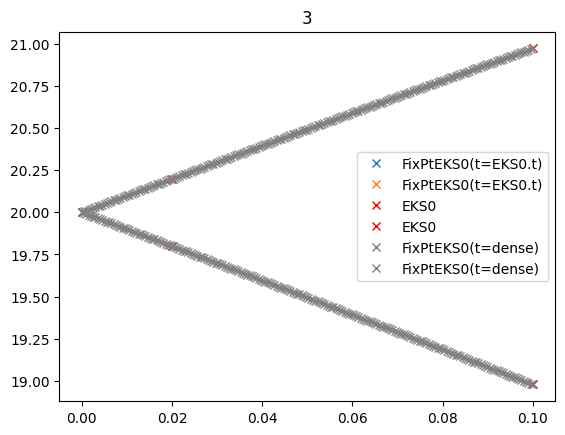

In [12]:
plt.title(len(fixptsol.t))

style = {"linestyle": "None", "marker": "x"}
plt.plot(fixptsol.t, fixptsol.u, **style, label="FixPtEKS0(t=EKS0.t)")
plt.plot(ek0sol.t, ek0sol.u, **style, color="red", linewidth=3, label="EKS0")
plt.plot(fixptsol2.t, fixptsol2.u, **style, color="gray", label="FixPtEKS0(t=dense)")
plt.legend()
# plt.ylim((-20, 30))
plt.show()

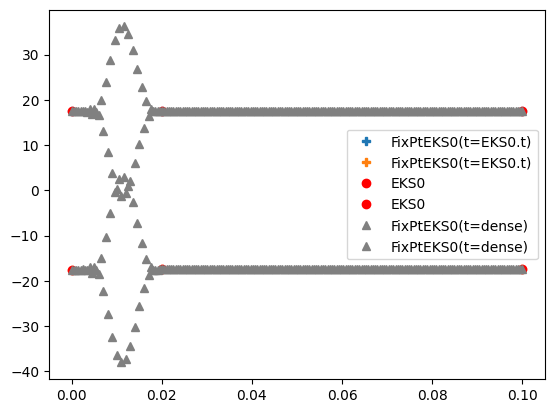

In [11]:
plt.plot(
    fixptsol.t,
    fixptsol.marginals.mean[:, -1, :],
    linestyle="None",
    marker="P",
    label="FixPtEKS0(t=EKS0.t)",
)
plt.plot(
    ek0sol.t,
    ek0sol.marginals.mean[:, -1, :],
    linestyle="None",
    marker="o",
    color="red",
    label="EKS0",
)
plt.plot(
    fixptsol2.t,
    fixptsol2.marginals.mean[:, -1, :],
    linestyle="None",
    marker="^",
    color="gray",
    label="FixPtEKS0(t=dense)",
)
# plt.ylim((-30, 30))
# plt.xlim((8, 9))
plt.legend()
plt.show()